In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# GPU设置

In [2]:
import os
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 搭建数据集

In [3]:
from Pkgs.Ds_Builder import Dataset

Ds = Dataset(
    file_train = '..\\Data\\SpecnSpeed_data.csv', 
    label_length = 2, 
    label_preprocessing = 'Lzz_norm', 
    data_preprocessing = 'Lzz_norm')

Ds.set_test_data('..\\Data\\SpecnSpeed_data_test.csv')

Training_samples: 77158
Testing_samples: 10190


# 搭建ZZ_NET

In [4]:
from Pkgs.ZZ_Net_Builder import ZZ_Net

ZZ = ZZ_Net(
    NN_type = 'R',
    task_name = 'Spec2speed',
    inputs = Ds.input_length,
    outputs = Ds.output_length, 
    nodes = 50, 
    levels = 2, 
    stacks = 2, 
    augmentation = ['Noise(0.1)', 'Mask(0.3)'],
    activation = tf.nn.relu, 
    normalization = None, 
    dropout_rate = 0.)

Model: "zz_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starter_block (Starter_block multiple                  64100     
_________________________________________________________________
res_block (Res_block)        multiple                  5100      
_________________________________________________________________
res_block_1 (Res_block)      multiple                  5100      
_________________________________________________________________
trans_block (Trans_block)    multiple                  5100      
_________________________________________________________________
res_block_2 (Res_block)      multiple                  20200     
_________________________________________________________________
res_block_3 (Res_block)      multiple                  20200     
_________________________________________________________________
final_block (Final_block)    multiple                  202

In [ ]:
from Pkgs.ZZ_Net_Builder import ZZ_Linear

ZZ = ZZ_Linear(
    NN_type = 'R',
    task_name = 'spec2speed',
    inputs = Ds.input_length,
    outputs = Ds.output_length, 
    augmentation = ['Noise(0.1)', 'Mask(0.1)'])

# 训练ZZ_NET

In [5]:
from Pkgs.ZZ_Net_Trainer import ZZ_Trainer

zzT = ZZ_Trainer(Ds, ZZ, total_iteration = 200000, learning_rate = 1e-3, batch_size = 200)
zzT.train(zzT.total_iteration)

0 , Train:  1.0751  , Test:  1.14153
4000 , Train:  0.0494  , Test:  0.05876
8000 , Train:  0.0224  , Test:  0.03454
12000 , Train:  0.01627  , Test:  0.02573
16000 , Train:  0.02171  , Test:  0.02766
20000 , Train:  0.01114  , Test:  0.0198
24000 , Train:  0.01262  , Test:  0.02027
28000 , Train:  0.01221  , Test:  0.01982
32000 , Train:  0.00944  , Test:  0.01909
36000 , Train:  0.00928  , Test:  0.01785
40000 , Train:  0.00889  , Test:  0.01922
44000 , Train:  0.00911  , Test:  0.02078
48000 , Train:  0.0083  , Test:  0.01638
52000 , Train:  0.00741  , Test:  0.01694
56000 , Train:  0.00676  , Test:  0.01523
60000 , Train:  0.00822  , Test:  0.01911
64000 , Train:  0.00644  , Test:  0.0167
68000 , Train:  0.00718  , Test:  0.01768
72000 , Train:  0.00618  , Test:  0.01985
76000 , Train:  0.00601  , Test:  0.01761
80000 , Train:  0.00559  , Test:  0.01511
84000 , Train:  0.00579  , Test:  0.01564
88000 , Train:  0.00556  , Test:  0.01705
92000 , Train:  0.00553  , Test:  0.01743
9600

# 验证ZZ_NET

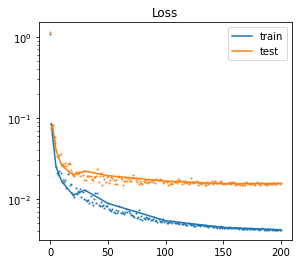

,1000,2000,5000,10000,20000,30000,50000,100000,150000,200000
Training_loss,0.084961,0.060216,0.025059,0.016407,0.011137,0.012877,0.008847,0.005395,0.004471,0.004167
Testing_loss,0.075286,0.081851,0.039983,0.025921,0.019802,0.022100,0.019424,0.016623,0.015421,0.015564


In [6]:
zzT.Validate([1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 150000, 200000])

In [ ]:
ZZ.visualize(Ds.data_train[0:100])

# 输出ZZ_NET结果

In [7]:
label_train_predict = ZZ.predict(Ds.data_train, batch_size = 1000)
label_test_predict = ZZ.predict(Ds.data_test, batch_size = 1000)

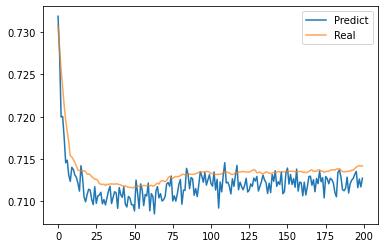

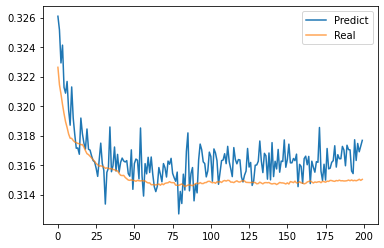

In [8]:
#画一些图什么的Train
Rnd_init = int(np.random.random()*(len(label_train_predict) - 200))
for i in range(Ds.output_length):
    plt.plot(np.arange(200), label_train_predict[Rnd_init:Rnd_init + 200, i], label = 'Predict')
    plt.plot(np.arange(200), Ds.label_train[Rnd_init:Rnd_init + 200, i], label = 'Real', alpha = .7)
    plt.legend()
    plt.show()

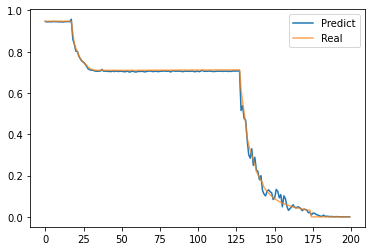

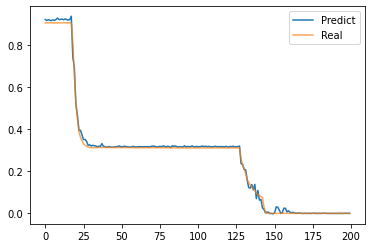

In [9]:
#又画一些图什么的Test
Rnd_init = int(np.random.random()*(len(label_test_predict) - 200))
for i in range(Ds.output_length):
    plt.plot(np.arange(200), label_test_predict[Rnd_init:Rnd_init + 200, i], label = 'Predict')
    plt.plot(np.arange(200), Ds.label_test[Rnd_init:Rnd_init + 200, i], label = 'Real', alpha = .7)
    plt.legend()
    plt.show()

In [10]:
#输出结果
label_predict = Ds.recover_label(label_test_predict)
label_real = Ds.recover_label(Ds.label_test)

labels = ['Predicted_' + str(i) for i in range(label_real.shape[1])] + ['Real_' + str(i) for i in range(label_real.shape[1])]
result = np.concatenate((label_predict, label_real), axis = 1)

pd.DataFrame(result, columns = labels).to_csv('Results\\Result_' + ZZ.task_name + '.csv', index = False)

# 保存ZZ_NET模型

In [11]:
tf.keras.models.save_model(ZZ, 'Saved_Models\\ZZ' + ZZ.type + '_' + ZZ.task_name)

INFO:tensorflow:Assets written to: Saved_Models\ZZR_Spec2speed\assets


# 剪裁和保存Dataset

In [12]:
import copy
Ds2 = copy.deepcopy(Ds)
Ds2.slim()

Dsfile = open('Ds\\Ds_' + ZZ.task_name,'wb')
pickle.dump(Ds2, Dsfile)
Dsfile.close()

This Dataset has been pruned.


# 加载模型实现端到端推理

In [13]:
from Pkgs.ZZ_Net_Portable import Portable_ZZ

ZZr = Portable_ZZ('Saved_Models\\ZZ' + ZZ.type + '_' + ZZ.task_name, 'Ds\\Ds_' + ZZ.task_name)